In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Embedding, \
    Dot, Flatten, Concatenate, Dense, Layer

from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Zeros, glorot_normal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
class Linear(Layer):
 
    def __init__(self, l2_reg=0.0, mode=2, use_bias=True, **kwargs):
 
        self.l2_reg = l2_reg
        if mode not in [0, 1, 2]:
            raise ValueError("mode must be 0, 1 or 2")
        self.mode = mode
        self.use_bias = use_bias
        super(Linear, self).__init__(**kwargs)
 
    def build(self, input_shape):
        if self.use_bias:
            self.bias = self.add_weight(name='linear_bias',
                                        shape=(1,),
                                        initializer=tf.keras.initializers.Zeros(),
                                        trainable=True)
            
        if self.mode == 1:
            self.kernel = self.add_weight(
                'linear_kernel',
                shape=[int(input_shape[-1]), 1],
                initializer=tf.keras.initializers.glorot_normal(),
                regularizer=tf.keras.regularizers.l2(self.l2_reg),
                trainable=True)
            
        elif self.mode == 2 :
            self.kernel = self.add_weight(
                'linear_kernel',
                shape=[int(input_shape[1][-1]), 1],
                initializer=tf.keras.initializers.glorot_normal(),
                regularizer=tf.keras.regularizers.l2(self.l2_reg),
                trainable=True)
 
        super(Linear, self).build(input_shape)
 
    def call(self, inputs, **kwargs):
        if self.mode == 0:
            sparse_input = inputs
            linear_logit = tf.reduce_sum(sparse_input, axis=-1, keepdims=True)
        elif self.mode == 1:
            dense_input = inputs
            fc = tf.tensordot(dense_input, self.kernel, axes=(-1, 0))
            linear_logit = fc
        else:
            sparse_input, dense_input = inputs
            fc = tf.tensordot(dense_input, self.kernel, axes=(-1, 0))
            linear_logit = tf.reduce_sum(sparse_input, axis=-1, keepdims=False) + fc
        if self.use_bias:
            linear_logit += self.bias
 
        return linear_logit
 
    def compute_output_shape(self, input_shape):
        return (None, 1)
 
    def compute_mask(self, inputs, mask):
        return None
 
    def get_config(self, ):
        config = {'mode': self.mode, 'l2_reg': self.l2_reg,'use_bias':self.use_bias}
        base_config = super(Linear, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [3]:
class FM(Layer):

    def __init__(self, **kwargs):

        super(FM, self).__init__(**kwargs)

    def build(self, input_shape):
        if len(input_shape) != 3:
            raise ValueError("Unexpected inputs dimensions % d,\
                             expect to be 3 dimensions" % (len(input_shape)))

        super(FM, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, inputs, **kwargs):

        if K.ndim(inputs) != 3:
            raise ValueError(
                "Unexpected inputs dimensions %d, expect to be 3 dimensions"
                % (K.ndim(inputs)))

        concated_embeds_value = inputs

        square_of_sum = tf.square(tf.reduce_sum(concated_embeds_value, axis=1, keepdims=True))
        sum_of_square = tf.reduce_sum(concated_embeds_value*concated_embeds_value, axis=1, keepdims=True)
        cross_term = square_of_sum - sum_of_square
        
        cross_term = 0.5 * tf.reduce_sum(cross_term, axis=2, keepdims=False)
        return cross_term

    def compute_output_shape(self, input_shape):
        return (None, 1)

In [4]:
class DNN(Layer):
    def __init__(self, hidden_units, activation='relu', l2_reg=0, \
                 dropout_rate=0, use_bn=False, seed=1024, **kwargs):
        self.hidden_units = hidden_units
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.seed = seed
        self.l2_reg = l2_reg
        self.use_bn = use_bn
        super(DNN, self).__init__(**kwargs)
 
    def build(self, input_shape):
        input_size = input_shape[-1]
        hidden_units = [int(input_size)] + list(self.hidden_units)
        self.kernels = [self.add_weight(name='kernel' + str(i),
                                        shape=(hidden_units[i], hidden_units[i + 1]),
                                        initializer=glorot_normal(seed=self.seed),
                                        regularizer=l2(self.l2_reg),
                                        trainable=True) for i in range(len(self.hidden_units))]
        self.bias = [self.add_weight(name='bias' + str(i),
                                     shape=(self.hidden_units[i],),
                                     initializer=Zeros(),
                                     trainable=True) for i in range(len(self.hidden_units))]
        if self.use_bn:
            self.bn_layers = [tf.keras.layers.BatchNormalization() for _ in range(len(self.hidden_units))]
 
        self.dropout_layers = [tf.keras.layers.Dropout(self.dropout_rate, seed=self.seed + i) for i in
                               range(len(self.hidden_units))]
 
        self.activation_layers = [tf.keras.layers.Activation(self.activation) \
                                  for _ in range(len(self.hidden_units))]
        
        super(DNN, self).build(input_shape)
 
    def call(self, inputs, training=None, **kwargs):
 
        deep_input = inputs
 
        for i in range(len(self.hidden_units)):
            fc = tf.nn.bias_add(tf.tensordot(
                deep_input, self.kernels[i], axes=(-1, 0)), self.bias[i])

            if self.use_bn:
                fc = self.bn_layers[i](fc, training=training)
 
            fc = self.activation_layers[i](fc)
            fc = self.dropout_layers[i](fc, training=training)
            
            deep_input = fc
 
        return deep_input
 
    def compute_output_shape(self, input_shape):
        if len(self.hidden_units) > 0:
            shape = input_shape[:-1] + (self.hidden_units[-1],)
        else:
            shape = input_shape
 
        return tuple(shape)
 
    def get_config(self, ):
        config = {'activation': self.activation, 'hidden_units': self.hidden_units,
                  'l2_reg': self.l2_reg, 'use_bn': self.use_bn, 'dropout_rate': self.dropout_rate, 'seed': self.seed}
        base_config = super(DNN, self).get_config()
        
        return dict(list(base_config.items()) + list(config.items()))

In [5]:
# 读取数据
df_data = pd.read_csv('train.csv')


# 类别变量重新编码
# 数值变量，用0填充缺失值
 
sparse_feature_list = ["Pclass", "Sex", "Cabin", "Embarked"]
dense_feature_list = ["Age", "SibSp", "Parch", "Fare"]

sparse_feature_reindex_dict = {}
for i in sparse_feature_list:
    cur_sparse_feature_list = df_data[i].unique()
    
    sparse_feature_reindex_dict[i] = dict(zip(cur_sparse_feature_list, \
        range(1, len(cur_sparse_feature_list)+1)
                                     )
                                 )
    
    df_data[i] = df_data[i].map(sparse_feature_reindex_dict[i])


for j in dense_feature_list:
    df_data[j] = df_data[j].fillna(0)

In [6]:
# 分割数据集

data = df_data[sparse_feature_list + dense_feature_list]
label = df_data["Survived"].values

xtrain, xtest, ytrain, ytest = train_test_split(data, label, test_size=0.2, random_state=2020)


In [7]:
xtrain_data = {"Pclass": np.array(xtrain["Pclass"]), \
              "Sex": np.array(xtrain["Sex"]), \
              "Cabin": np.array(xtrain["Cabin"]), \
              "Embarked": np.array(xtrain["Embarked"]), \
              "Age": np.array(xtrain["Age"]), \
              "SibSp": np.array(xtrain["SibSp"]), \
              "Parch": np.array(xtrain["Parch"]), \
              "Fare": np.array(xtrain["Fare"])}
 
xtest_data = {"Pclass": np.array(xtest["Pclass"]), \
              "Sex": np.array(xtest["Sex"]), \
              "Cabin": np.array(xtest["Cabin"]), \
              "Embarked": np.array(xtest["Embarked"]), \
              "Age": np.array(xtest["Age"]), \
              "SibSp": np.array(xtest["SibSp"]), \
              "Parch": np.array(xtest["Parch"]), \
              "Fare": np.array(xtest["Fare"])}

In [8]:
def input_embedding_layer(
    shape=1, \
    name=None, \
    vocabulary_size=1, \
    embedding_dim=1):
    
    input_layer = Input(shape=[shape, ], name=name)
    embedding_layer = Embedding(vocabulary_size, embedding_dim)(input_layer)
    
    return input_layer, embedding_layer

In [9]:
def deepfm(sparse_feature_list, \
        sparse_feature_reindex_dict, \
        dense_feature_list, \
        dnn_hidden_units=(128, 128), \
        l2_reg_embedding=1e-5, \
        l2_reg_linear=1e-5, \
        l2_reg_dnn=0, \
        init_std=0.0001, \
        seed=1024, \
        bi_dropout=0.2,
        dnn_dropout=0.2, \
        dnn_activation='relu', \
        task='binary'):
    
    sparse_input_layer_list = []
    sparse_embedding_layer_list = []
    
    dense_input_layer_list = []
 
    
    # 1. Input & Embedding sparse features
    for i in sparse_feature_list:
        shape = 1
        name = i
        vocabulary_size = len(sparse_feature_reindex_dict[i]) + 1
        embedding_dim = 64
        
        cur_sparse_feaure_input_layer, cur_sparse_feaure_embedding_layer = \
            input_embedding_layer(
                shape = shape, \
                name = name, \
                vocabulary_size = vocabulary_size, \
                embedding_dim = embedding_dim)
        
        sparse_input_layer_list.append(cur_sparse_feaure_input_layer)
        sparse_embedding_layer_list.append(cur_sparse_feaure_embedding_layer)
 
    
    # 2. Input dense features
    for j in dense_feature_list:
        dense_input_layer_list.append(Input(shape=(1, ), name=j))
    
    
    # === linear ===
    sparse_linear_input = Concatenate(axis=-1)(sparse_embedding_layer_list)
    dense_linear_input = Concatenate(axis=-1)(dense_input_layer_list)
    linear_logit = Linear()([sparse_linear_input, dense_linear_input])
 
    
    # === fm cross ===
    fm_logit = FM()(Concatenate(axis=1)(sparse_embedding_layer_list))
    
   
    # === DNN cross ===
    dnn_input = Concatenate(axis=-1)([Flatten()(sparse_linear_input), dense_linear_input])
    dnn_output = DNN(dnn_hidden_units, dnn_activation, l2_reg_dnn, dnn_dropout, False, seed)(dnn_input)
    dnn_logit = tf.keras.layers.Dense(1, use_bias=False, activation=None)(dnn_output)
 
    
    # === finally dense ===
    out = Dense(1, activation='sigmoid')(tf.keras.layers.add([linear_logit, fm_logit, dnn_logit]))
    deepfm_model = Model(inputs = sparse_input_layer_list + dense_input_layer_list, outputs=out)
    
    return deepfm_model

In [10]:
deepfm_model = deepfm(sparse_feature_list, \
              sparse_feature_reindex_dict, \
              dense_feature_list)

In [11]:
print(deepfm_model.summary())


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Pclass (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Sex (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
Cabin (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
Embarked (InputLayer)           [(None, 1)]          0                                            
______________________________________________________________________________________________

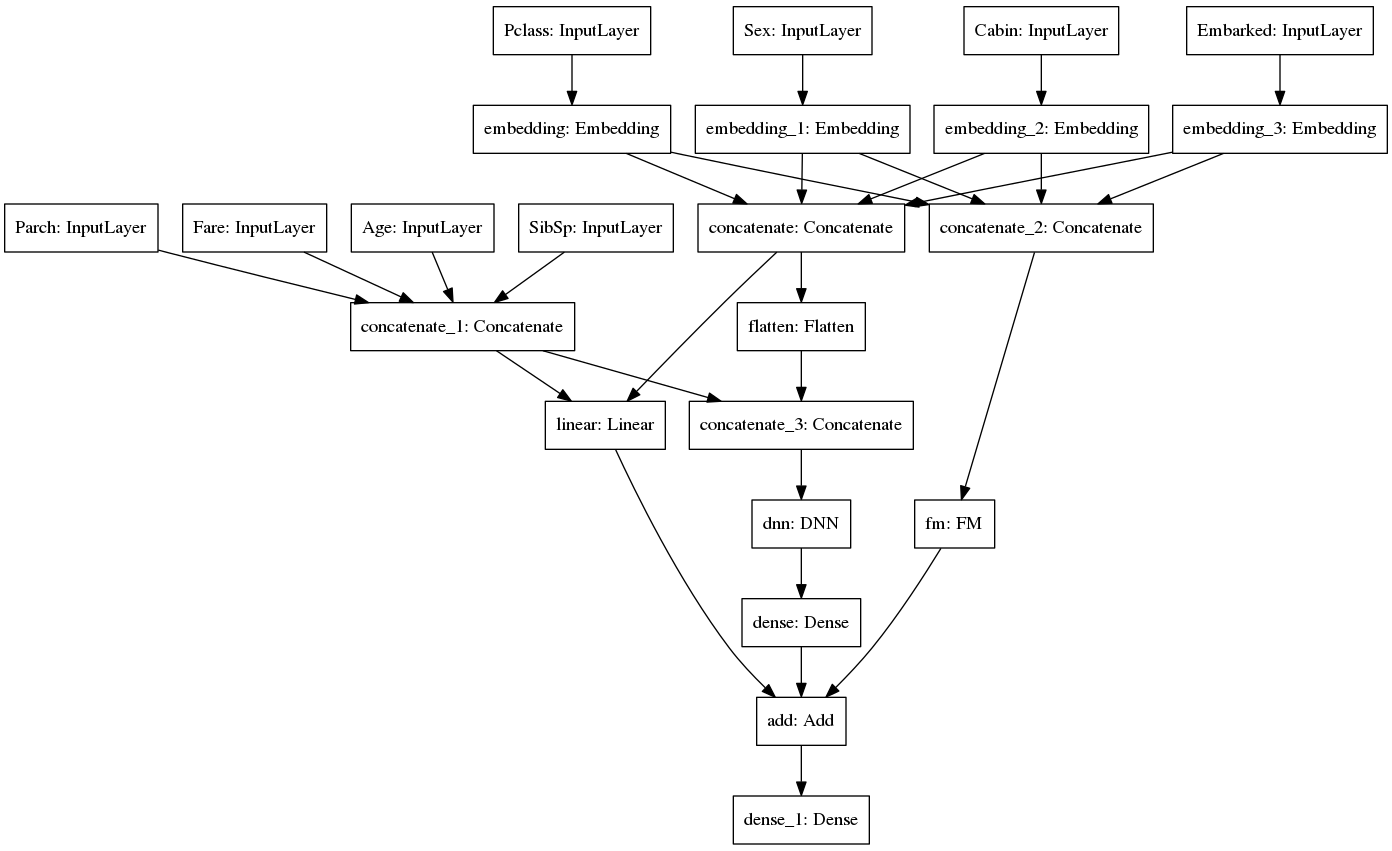

In [12]:
plot_model(deepfm_model, to_file='deepfm_model.png')


In [13]:
deepfm_model.compile(loss='binary_crossentropy', \
        optimizer=Adam(lr=1e-3), \
        metrics=['accuracy'])
 
history = deepfm_model.fit(xtrain_data, ytrain, epochs=5, batch_size=32, validation_data=(xtest_data, ytest))

Train on 712 samples, validate on 179 samples
Epoch 1/5
712/712 [==============================] - 2s 3ms/sample - loss: 1.2442 - accuracy: 0.5758 - val_loss: 0.7062 - val_accuracy: 0.6425
Epoch 2/5
712/712 [==============================] - 0s 153us/sample - loss: 0.7108 - accuracy: 0.7135 - val_loss: 0.6843 - val_accuracy: 0.6872
Epoch 3/5
712/712 [==============================] - 0s 153us/sample - loss: 0.5470 - accuracy: 0.7430 - val_loss: 0.6003 - val_accuracy: 0.7151
Epoch 4/5
712/712 [==============================] - 0s 151us/sample - loss: 0.5368 - accuracy: 0.7612 - val_loss: 0.5636 - val_accuracy: 0.7542
Epoch 5/5
712/712 [==============================] - 0s 148us/sample - loss: 0.5056 - accuracy: 0.7963 - val_loss: 0.6268 - val_accuracy: 0.7039


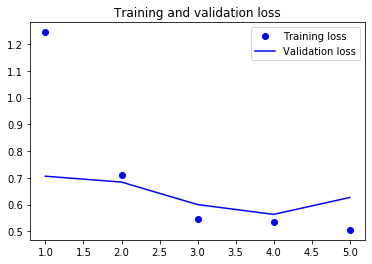

None


In [14]:
import matplotlib.pyplot as plt
 
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
print(plt.show())